<a href="https://colab.research.google.com/github/rtajeong/M1_new/blob/main/gg16_spam_rev5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 베이즈 텍스트 분석
- 메일이 스팸메일인지 아닌지 예측

In [ ]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn import metrics

데이터 읽기
--

- data from 'https://www.kaggle.com/ishansoni/sms-spam-collection-dataset/data'
- download the data file (spam.csv) from the above site and save it in the current directory
- if you use Colab, just upload the file to the colab working directory

In [ ]:
!curl -L https://bit.ly/2WC9nvn -o spam.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   141  100   141    0     0    759      0 --:--:-- --:--:-- --:--:--   758
100   120  100   120    0     0    250      0 --:--:-- --:--:-- --:--:--   250
100    17  100    17    0     0     19      0 --:--:-- --:--:-- --:--:--    19
100  488k  100  488k    0     0   385k      0  0:00:01  0:00:01 --:--:-- 8883k


In [ ]:
!head -3 spam.csv

"type","text"
"ham","Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat..."
"ham","Ok lar... Joking wif u oni..."


In [ ]:
sms = pd.read_csv('spam.csv', encoding = 'latin-1')
sms.head()

,type,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [ ]:
# sms = pd.read_csv('spam.csv', encoding = 'latin-1')
# sms.head()
# Drop the extra columns and rename columns to make it look the same as the text
# sms = sms.drop(labels = ["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], axis = 1)
# sms.columns = ["type", "text"]

In [ ]:
sms.head(3)

,type,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...


In [ ]:
sms.shape

(5574, 2)

In [ ]:
sms['type'].value_counts()

,count
type,
ham,4827
spam,747


In [ ]:
sms_corpus = sms['text']

In [ ]:
type(sms_corpus), type(sms['type'].value_counts())

(pandas.core.series.Series, pandas.core.series.Series)

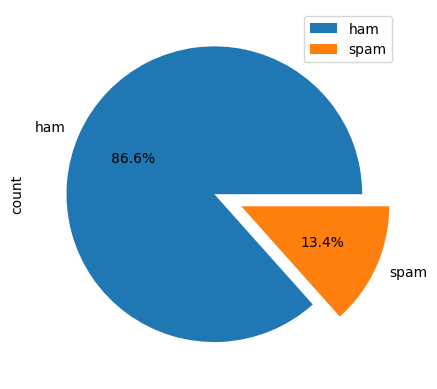

In [ ]:
sms['type'].value_counts().plot(kind='pie', explode=[0, 0.2], autopct='%1.1f%%')
plt.legend(['ham', 'spam'])
plt.show()

## 단어-문서 행렬 (Word-Document Matrix) 생성

In [ ]:
vectorizer = CountVectorizer(min_df=10)  # 10번 이하로 발생한 단어 무시
X = vectorizer.fit_transform(sms_corpus)

In [ ]:
X.shape

(5574, 1020)

In [ ]:
vectorizer.get_feature_names_out()[:10]

array(['00', '000', '03', '04', '0800', '08000839402', '08000930705',
       '10', '100', '1000'], dtype=object)

In [ ]:
vectorizer.get_feature_names_out()[-10:]   # 마지막 단어 10개만

array(['yesterday', 'yet', 'yo', 'you', 'your', 'yours', 'yourself', 'yr',
       'yup', 'ã¼'], dtype=object)

In [ ]:
y = sms['type']
y[:5]

,type
0,ham
1,ham
2,spam
3,ham
4,ham


In [ ]:
X.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [ ]:
# X.toarray(): transform a sparse matrix into a matrix format
X[:5].toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [ ]:
# for exercise
maxidx = X[:5].toarray().argmax(axis=1); maxidx
maxcounts = X[:5].toarray().max(axis=1)
maxwords = [vectorizer.get_feature_names_out()[i] for i in maxidx]

print(maxidx, maxcounts, maxwords)

[ 92 463 867 732 393] [1 1 3 2 2] ['available', 'lar', 'to', 'say', 'he']


In [ ]:
# 전체 max 단어
print('max counts: {}'.format(X.toarray().sum(0).max()))
print('index for max counts: {}'.format(X.toarray().sum(0).argmax()))
print('word for max counts: {}'.format(vectorizer.get_feature_names_out()[X.toarray().sum(0).argmax()]))

max counts: 2253
index for max counts: 867
word for max counts: to


In [ ]:
# 전체 5개 max 단어
iidx = X.toarray().sum(0).argsort()[-5:][::-1]
print(iidx)
print([vectorizer.get_feature_names_out()[i] for i in iidx])
print([X.toarray().sum(0)[i] for i in iidx])

[ 867 1013  841   67  434]
['to', 'you', 'the', 'and', 'in']
[2253, 2244, 1339, 980, 903]


## Bayes Algorithm 적용

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X.toarray(), y, test_size=0.25)

In [ ]:
clf = MultinomialNB()
clf.fit(X_train, y_train)
clf.score(X_test, y_test).round(4)

0.9813

In [ ]:
y_predict = clf.predict(X_test)

In [ ]:
metrics.confusion_matrix(y_test, y_predict)

array([[1168,   15],
       [  11,  200]])

In [ ]:
print(metrics.classification_report(y_test, y_predict))

              precision    recall  f1-score   support

         ham       0.99      0.99      0.99      1183
        spam       0.93      0.95      0.94       211

    accuracy                           0.98      1394
   macro avg       0.96      0.97      0.96      1394
weighted avg       0.98      0.98      0.98      1394



#### putting altogether

In [ ]:
sms = pd.read_csv('spam.csv', encoding = 'latin-1')
sms_corpus = sms['text']

vectorizer = CountVectorizer()
X = vectorizer.fit_transform(sms_corpus)
y = sms['type']

X_train, X_test, y_train, y_test = train_test_split(X.toarray(), y, test_size=0.25)

clf = MultinomialNB()
clf.fit(X_train, y_train)
print("test score: ", clf.score(X_test, y_test).round(4))


test score:  0.977


- deploy example

In [ ]:
new_mail = ["free coupon, buy one get one free",
            "I like you very much."]

new_X = vectorizer.transform(new_mail)
clf.predict(new_X.toarray())

array(['ham', 'ham'], dtype='<U4')

## 다른 알고리즘 (모델) 적용

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
mode1 = SGDClassifier()
mode1.fit(X_train, y_train)
mode1.score(X_test, y_test)

0.9835007173601148

In [ ]:
mod1 = RandomForestClassifier(n_estimators=100)
mod1.fit(X_train, y_train)
mod1.score(X_test, y_test)

0.9842180774748924

In [ ]:
mod1 = DecisionTreeClassifier()
mod1.fit(X_train, y_train)
mod1.score(X_test, y_test)

0.9727403156384505

In [ ]:
mod1 = LogisticRegression()
mod1.fit(X_train, y_train)
mod1.score(X_test, y_test)

0.9849354375896701

# Exercise

- CountVectorizer
  - 정규표현식을 사용해 토큰을 추출한다.
  - 모두 소문자로 변환시키기 때문에 good, Good, gOod이 모두 같은 특성이 된다.
  - 의미 없는 특성을 많이 생성하기 때문에 적어도 두 개의 문서에 나타난 토큰만을 사용한다.
  - min_df로 토큰이 나타날 최소 문서 개수를 지정할 수 있다.

In [ ]:
# countvectorizer example
from sklearn.feature_extraction.text import CountVectorizer
corpus = [
        'This is the first document.',
        'This document is the second document.',
        'And this is the third one.',
        'Is this the first document?',
]
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(corpus)

In [ ]:
X.toarray()

array([[0, 1, 1, 1, 0, 0, 1, 0, 1],
       [0, 2, 0, 1, 0, 1, 1, 0, 1],
       [1, 0, 0, 1, 1, 0, 1, 1, 1],
       [0, 1, 1, 1, 0, 0, 1, 0, 1]])

In [ ]:
# print(X)
print(vectorizer.get_feature_names_out())     # same as vectorizer.get_feature_names()
print(X.toarray())
X.shape

['and' 'document' 'first' 'is' 'one' 'second' 'the' 'third' 'this']
[[0 1 1 1 0 0 1 0 1]
 [0 2 0 1 0 1 1 0 1]
 [1 0 0 1 1 0 1 1 1]
 [0 1 1 1 0 0 1 0 1]]


(4, 9)

In [ ]:
# list 연습
a = [1,2,3,4,5]
good=[0,2]
[a[i] for i in good]

[1, 3]

In [ ]:
# argmax 연습
a = np.arange(6).reshape(2,3) + 10
print(a)
np.argmax(a), np.argmax(a, axis=0), np.argmax(a, axis=1)


[[10 11 12]
 [13 14 15]]


(5, array([1, 1, 1]), array([2, 2]))